# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.293122,False,0.263783
1,1.119633,True,6.319526
2,1.582717,True,5.428521
3,1.396714,True,5.374532
4,2.269855,True,6.850925
...,...,...,...
995,0.825839,True,6.059904
996,0.658618,True,4.308807
997,1.581109,True,6.757601
998,1.554820,False,1.852797


<AxesSubplot:xlabel='v0'>

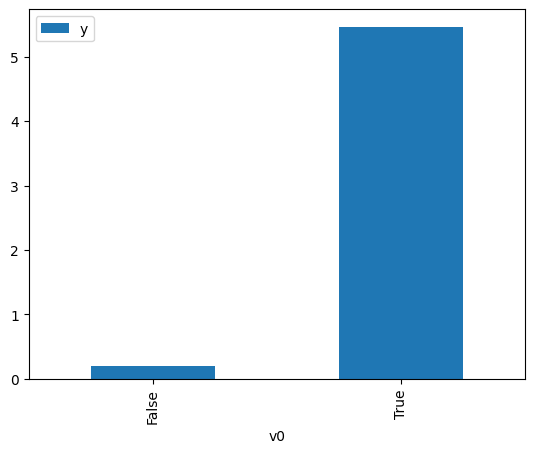

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

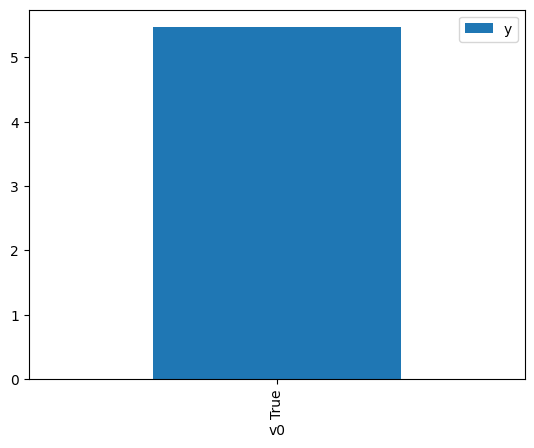

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.386275,False,-0.590913,0.325274,3.074330
1,-0.662693,False,-2.345637,0.841250,1.188707
2,-1.026152,False,0.559619,0.924013,1.082235
3,0.224994,False,1.973805,0.410702,2.434855
4,1.617062,False,0.288122,0.028131,35.547877
...,...,...,...,...,...
995,-1.439597,False,1.249141,0.969022,1.031968
996,0.764022,False,-0.473626,0.168976,5.917997
997,2.339796,False,-0.391517,0.005519,181.188593
998,1.756224,False,1.338199,0.020626,48.483013


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.423879,True,5.605433,0.995441,1.004580
1,0.811964,True,7.310871,0.845856,1.182234
2,1.545667,True,6.010666,0.967048,1.034075
3,1.276921,True,6.511528,0.940756,1.062975
4,1.399884,True,4.876382,0.954611,1.047547
...,...,...,...,...,...
995,1.767156,True,5.454695,0.979873,1.020541
996,0.789070,True,5.632283,0.838910,1.192023
997,0.658618,True,4.308807,0.794460,1.258717
998,-0.562438,True,2.846279,0.191786,5.214148


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.135e+04
Date:                Tue, 06 Sep 2022   Prob (F-statistic):                        0.00
Time:                        07:39:32   Log-Likelihood:                         -1399.2
No. Observations:                1000   AIC:                                      2802.
Df Residuals:                     998   BIC:                                      2812.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4852      0.038     12.689      0.000       0.410       0.560
x2             4.9989      0.057     87.011      0.000       4.886       5.112
==============================================================================
Omnibus:                        0.058   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.110
Skew:                           0.010   Prob(JB):                        0.947
Kurtosis:                       2.953   Cond. No.                         3.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""